# 02b: Simple Recurrence on MNIST

This notebook extends the single-layer experiments from `02_Single_layer_models` by adding a minimal recurrent mechanism. We compare a feed-forward baseline to multiple recurrent variants on the MNIST digits dataset and explore *outer-loop* recurrence that carries hidden state across mini-batches alongside other ways of injecting recurrence into the network.

## What you'll do
- Configure the MNIST data providers and inspect sample digits.
- Reuse utilities from notebook 02 to train a single-layer classifier.
- Introduce a simple gated recurrent unit (GRU) that processes each image row sequentially.
- Add a trivial outer-loop recurrence by carrying hidden state between batches.
- Explore two more recurrent mechanisms: a learnable initial hidden state and a bidirectional GRU.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Ensure plots render inline with a minimal style
plt.style.use('seaborn-v0_8-darkgrid')

# Ensure the repository root is importable before pulling in `mlp`
repo_root = Path.cwd()
if not (repo_root / 'data').is_dir() and (repo_root.parent / 'data').is_dir():
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from mlp import DEFAULT_SEED, data_providers

os.environ.setdefault('MLP_DATA_DIR', str(repo_root / 'data'))
print(f"MLP_DATA_DIR -> {os.environ['MLP_DATA_DIR']}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


def set_seed(seed: int = DEFAULT_SEED) -> None:
    """Set seeds for reproducibility across NumPy and PyTorch."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(DEFAULT_SEED)


/usr/local/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


MLP_DATA_DIR -> /Users/ewkoch/repos/mlp/data
Using device: cpu


In [2]:
TRAIN_BATCH_SIZE = 128
TRAIN_BATCHES = 200  # keep runtime reasonable
VALID_BATCHES = 50
TEST_BATCHES = 50


def make_data_providers(seed: int = DEFAULT_SEED):
    """Construct fresh MNIST providers with a deterministic shuffle order."""
    train_rng = np.random.RandomState(seed)
    train_dp = data_providers.MNISTDataProvider(
        'train',
        batch_size=TRAIN_BATCH_SIZE,
        max_num_batches=TRAIN_BATCHES,
        shuffle_order=True,
        rng=train_rng,
    )
    valid_dp = data_providers.MNISTDataProvider(
        'valid',
        batch_size=TRAIN_BATCH_SIZE,
        max_num_batches=VALID_BATCHES,
        shuffle_order=False,
    )
    test_dp = data_providers.MNISTDataProvider(
        'test',
        batch_size=TRAIN_BATCH_SIZE,
        max_num_batches=TEST_BATCHES,
        shuffle_order=False,
    )
    return train_dp, valid_dp, test_dp


train_dp_preview, valid_dp_preview, test_dp_preview = make_data_providers()
first_batch_inputs, first_batch_targets = next(iter(train_dp_preview))
print(f"Batch inputs shape: {first_batch_inputs.shape}")
print(f"Batch targets shape: {first_batch_targets.shape}")
train_dp_preview.reset()


Batch inputs shape: (128, 784)
Batch targets shape: (128, 10)


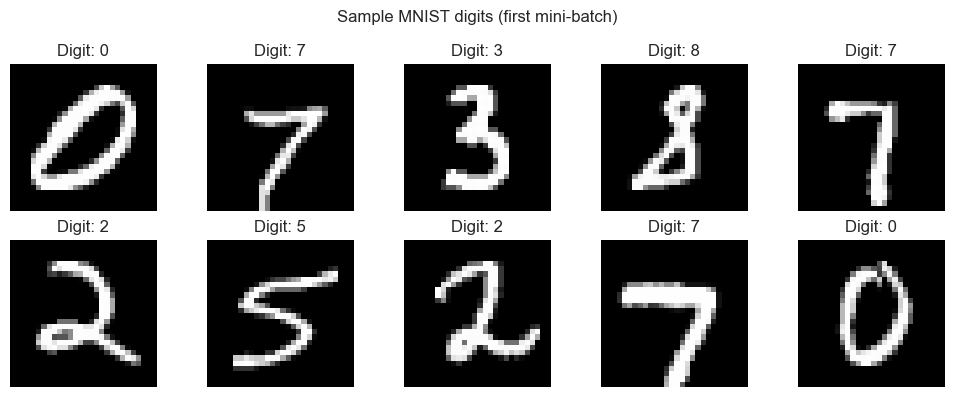

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flat):
    image = first_batch_inputs[idx].reshape(28, 28)
    label = int(np.argmax(first_batch_targets[idx]))
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Digit: {label}")
    ax.axis('off')
fig.suptitle('Sample MNIST digits (first mini-batch)')
plt.tight_layout()
plt.show()


## Training utilities

We reuse the mini-batch providers from notebook 02 and add helper functions for accuracy tracking, epoch-level training/evaluation, and plotting.

In [4]:
from dataclasses import dataclass
from typing import Dict, Tuple


def one_hot_to_int(targets: np.ndarray) -> np.ndarray:
    """Convert one-hot encoded targets to integer class indices."""
    return np.argmax(targets, axis=1).astype(np.int64)


def accuracy_from_logits(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute average accuracy for predictions in `logits`."""
    return (logits.argmax(dim=1) == labels).float().mean().item()


@dataclass
class History:
    train_loss: list
    train_acc: list
    valid_loss: list
    valid_acc: list


@dataclass
class ExperimentResult:
    label: str
    color: str
    history: History
    test_metrics: Tuple[float, float]
    carry_state: bool


def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, data_provider, *, carry_state: bool) -> Tuple[float, float]:
    """Run one training epoch and return (loss, accuracy)."""
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    hidden = None
    data_provider.reset()
    for inputs, targets in data_provider:
        features = torch.from_numpy(inputs).to(device)
        labels = torch.from_numpy(one_hot_to_int(targets)).to(device)
        optimizer.zero_grad()
        logits, hidden = model(features, hidden)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * features.size(0)
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_examples += features.size(0)
        if carry_state and hidden is not None:
            hidden = hidden.detach()
        else:
            hidden = None
    data_provider.reset()
    return total_loss / total_examples, total_correct / total_examples


def evaluate(model: nn.Module, data_provider, *, carry_state: bool) -> Tuple[float, float]:
    """Evaluate the model and return (loss, accuracy)."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    hidden = None
    data_provider.reset()
    with torch.no_grad():
        for inputs, targets in data_provider:
            features = torch.from_numpy(inputs).to(device)
            labels = torch.from_numpy(one_hot_to_int(targets)).to(device)
            logits, hidden = model(features, hidden)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * features.size(0)
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_examples += features.size(0)
            if carry_state and hidden is not None:
                hidden = hidden.detach()
            else:
                hidden = None
    data_provider.reset()
    return total_loss / total_examples, total_correct / total_examples


def train_model(model: nn.Module, optimizer: torch.optim.Optimizer, train_dp, valid_dp, *, num_epochs: int, carry_state: bool) -> History:
    """Train `model` for `num_epochs` epochs and collect the metrics history."""
    hist = History(train_loss=[], train_acc=[], valid_loss=[], valid_acc=[])
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, optimizer, train_dp, carry_state=carry_state)
        valid_loss, valid_acc = evaluate(model, valid_dp, carry_state=carry_state)
        hist.train_loss.append(train_loss)
        hist.train_acc.append(train_acc)
        hist.valid_loss.append(valid_loss)
        hist.valid_acc.append(valid_acc)
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.3f} | train_acc={train_acc:.3f} | valid_acc={valid_acc:.3f}")
    return hist


## Models

We use two base networks and extend the recurrent version with optional mechanisms.

1. **SingleLayerClassifier** – the affine model from notebook 02.
2. **RowRecurrentClassifier** – a GRU that sweeps across each 28×28 image row-by-row and emits logits from the final hidden state. It supports:
   - a learnable initial hidden state (instead of zeros) that is shared across batches;
   - bidirectionality, processing the row sequence forward and backward.

The `forward` methods return `(logits, next_hidden)` so the training loop can optionally keep recurrence between batches.

In [5]:
class SingleLayerClassifier(nn.Module):
    """Single affine layer baseline."""

    def __init__(self, input_dim: int = 784, output_dim: int = 10):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor, hidden=None):
        logits = self.linear(x)
        return logits, None


class RowRecurrentClassifier(nn.Module):
    """Row-wise GRU with optional learnable initial state and bidirectionality."""

    def __init__(
        self,
        input_dim: int = 28,
        hidden_dim: int = 64,
        output_dim: int = 10,
        *,
        bidirectional: bool = False,
        learnable_init: bool = False,
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.learnable_init = learnable_init
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.readout = nn.Linear(hidden_dim * self.num_directions, output_dim)
        if learnable_init:
            init = torch.zeros(self.num_directions, 1, hidden_dim)
            nn.init.xavier_uniform_(init)
            self.init_hidden = nn.Parameter(init)
        else:
            self.register_parameter('init_hidden', None)

    def _initial_hidden(self, batch_size: int, device: torch.device):
        if self.init_hidden is None:
            return torch.zeros(self.num_directions, batch_size, self.hidden_dim, device=device)
        return self.init_hidden.expand(-1, batch_size, -1).contiguous().to(device)

    def forward(self, x: torch.Tensor, hidden=None):
        seq = x.view(x.size(0), 28, 28)
        if hidden is None:
            hidden = self._initial_hidden(seq.size(0), x.device)
        outputs, hidden = self.gru(seq, hidden)
        logits = self.readout(outputs[:, -1, :])
        return logits, hidden


## Experiment 1: Feed-forward baseline

We train the single-layer logistic regression model for a few epochs and record accuracy/loss.

In [6]:
NUM_EPOCHS = 5
EXPERIMENTS: Dict[str, ExperimentResult] = {}

train_dp_ffn, valid_dp_ffn, test_dp_ffn = make_data_providers(seed=DEFAULT_SEED)
model_ffn = SingleLayerClassifier().to(device)
optimizer_ffn = torch.optim.Adam(model_ffn.parameters(), lr=1e-3)

history_ffn = train_model(
    model_ffn,
    optimizer_ffn,
    train_dp_ffn,
    valid_dp_ffn,
    num_epochs=NUM_EPOCHS,
    carry_state=False,
)

test_metrics_ffn = evaluate(model_ffn, test_dp_ffn, carry_state=False)
EXPERIMENTS['ffn'] = ExperimentResult(
    label='Single layer (no recurrence)',
    color='#1f77b4',
    history=history_ffn,
    test_metrics=test_metrics_ffn,
    carry_state=False,
)


Epoch 01 | train_loss=0.950 | train_acc=0.800 | valid_acc=0.871
Epoch 02 | train_loss=0.476 | train_acc=0.881 | valid_acc=0.889
Epoch 03 | train_loss=0.402 | train_acc=0.894 | valid_acc=0.903
Epoch 04 | train_loss=0.361 | train_acc=0.903 | valid_acc=0.908
Epoch 05 | train_loss=0.328 | train_acc=0.911 | valid_acc=0.909


## Experiment 2: Recurrent model (hidden reset each batch)

We introduce a GRU that processes each image row sequentially, resetting the hidden state between mini-batches.

In [7]:
train_dp_rnn, valid_dp_rnn, test_dp_rnn = make_data_providers(seed=DEFAULT_SEED)
model_rnn = RowRecurrentClassifier(hidden_dim=64).to(device)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)

history_rnn = train_model(
    model_rnn,
    optimizer_rnn,
    train_dp_rnn,
    valid_dp_rnn,
    num_epochs=NUM_EPOCHS,
    carry_state=False,
)

test_metrics_rnn = evaluate(model_rnn, test_dp_rnn, carry_state=False)
EXPERIMENTS['rnn_reset'] = ExperimentResult(
    label='GRU (reset hidden each batch)',
    color='#ff7f0e',
    history=history_rnn,
    test_metrics=test_metrics_rnn,
    carry_state=False,
)


Epoch 01 | train_loss=1.439 | train_acc=0.512 | valid_acc=0.732
Epoch 02 | train_loss=0.615 | train_acc=0.807 | valid_acc=0.859
Epoch 03 | train_loss=0.397 | train_acc=0.881 | valid_acc=0.904
Epoch 04 | train_loss=0.285 | train_acc=0.918 | valid_acc=0.933
Epoch 05 | train_loss=0.218 | train_acc=0.938 | valid_acc=0.947


## Experiment 3: Trivial outer-loop recurrence

We carry the GRU hidden state between batches (detaching it each step to avoid backpropagating across batches) to demonstrate how an outer-loop recurrence affects optimisation.

In [8]:
train_dp_carry, valid_dp_carry, test_dp_carry = make_data_providers(seed=DEFAULT_SEED)
model_carry = RowRecurrentClassifier(hidden_dim=64).to(device)
optimizer_carry = torch.optim.Adam(model_carry.parameters(), lr=1e-3)

history_carry = train_model(
    model_carry,
    optimizer_carry,
    train_dp_carry,
    valid_dp_carry,
    num_epochs=NUM_EPOCHS,
    carry_state=True,
)

test_metrics_carry = evaluate(model_carry, test_dp_carry, carry_state=True)
EXPERIMENTS['rnn_carry'] = ExperimentResult(
    label='GRU (carry hidden across batches)',
    color='#2ca02c',
    history=history_carry,
    test_metrics=test_metrics_carry,
    carry_state=True,
)


Epoch 01 | train_loss=1.465 | train_acc=0.509 | valid_acc=0.721
Epoch 02 | train_loss=0.685 | train_acc=0.776 | valid_acc=0.817
Epoch 03 | train_loss=0.447 | train_acc=0.862 | valid_acc=0.878
Epoch 04 | train_loss=0.326 | train_acc=0.902 | valid_acc=0.919
Epoch 05 | train_loss=0.248 | train_acc=0.927 | valid_acc=0.932


## Experiment 4: Learnable initial hidden state

Instead of starting each sequence from zeros, we give the GRU a **trainable** initial hidden state that is learned jointly with the rest of the model. This shares information between sequences but without explicitly carrying state across batches.

In [9]:
train_dp_learned, valid_dp_learned, test_dp_learned = make_data_providers(seed=DEFAULT_SEED)
model_learned = RowRecurrentClassifier(hidden_dim=64, learnable_init=True).to(device)
optimizer_learned = torch.optim.Adam(model_learned.parameters(), lr=1e-3)

history_learned = train_model(
    model_learned,
    optimizer_learned,
    train_dp_learned,
    valid_dp_learned,
    num_epochs=NUM_EPOCHS,
    carry_state=False,
)

test_metrics_learned = evaluate(model_learned, test_dp_learned, carry_state=False)
EXPERIMENTS['rnn_learned_init'] = ExperimentResult(
    label='GRU (learnable initial hidden)',
    color='#d62728',
    history=history_learned,
    test_metrics=test_metrics_learned,
    carry_state=False,
)


Epoch 01 | train_loss=1.479 | train_acc=0.487 | valid_acc=0.722
Epoch 02 | train_loss=0.680 | train_acc=0.783 | valid_acc=0.842
Epoch 03 | train_loss=0.442 | train_acc=0.866 | valid_acc=0.892
Epoch 04 | train_loss=0.313 | train_acc=0.908 | valid_acc=0.923
Epoch 05 | train_loss=0.238 | train_acc=0.930 | valid_acc=0.933


## Experiment 5: Bidirectional recurrence

Finally, we allow the GRU to process each row sequence forward *and* backward and concatenate the resulting hidden states before classification.

In [10]:
train_dp_bi, valid_dp_bi, test_dp_bi = make_data_providers(seed=DEFAULT_SEED)
model_bi = RowRecurrentClassifier(hidden_dim=64, bidirectional=True).to(device)
optimizer_bi = torch.optim.Adam(model_bi.parameters(), lr=1e-3)

history_bi = train_model(
    model_bi,
    optimizer_bi,
    train_dp_bi,
    valid_dp_bi,
    num_epochs=NUM_EPOCHS,
    carry_state=False,
)

test_metrics_bi = evaluate(model_bi, test_dp_bi, carry_state=False)
EXPERIMENTS['rnn_bidirectional'] = ExperimentResult(
    label='Bidirectional GRU',
    color='#9467bd',
    history=history_bi,
    test_metrics=test_metrics_bi,
    carry_state=False,
)


Epoch 01 | train_loss=1.515 | train_acc=0.488 | valid_acc=0.713
Epoch 02 | train_loss=0.786 | train_acc=0.747 | valid_acc=0.804
Epoch 03 | train_loss=0.549 | train_acc=0.833 | valid_acc=0.869
Epoch 04 | train_loss=0.394 | train_acc=0.885 | valid_acc=0.903
Epoch 05 | train_loss=0.299 | train_acc=0.913 | valid_acc=0.919


## Compare learning curves

Solid lines show validation performance; dashed lines show training performance.

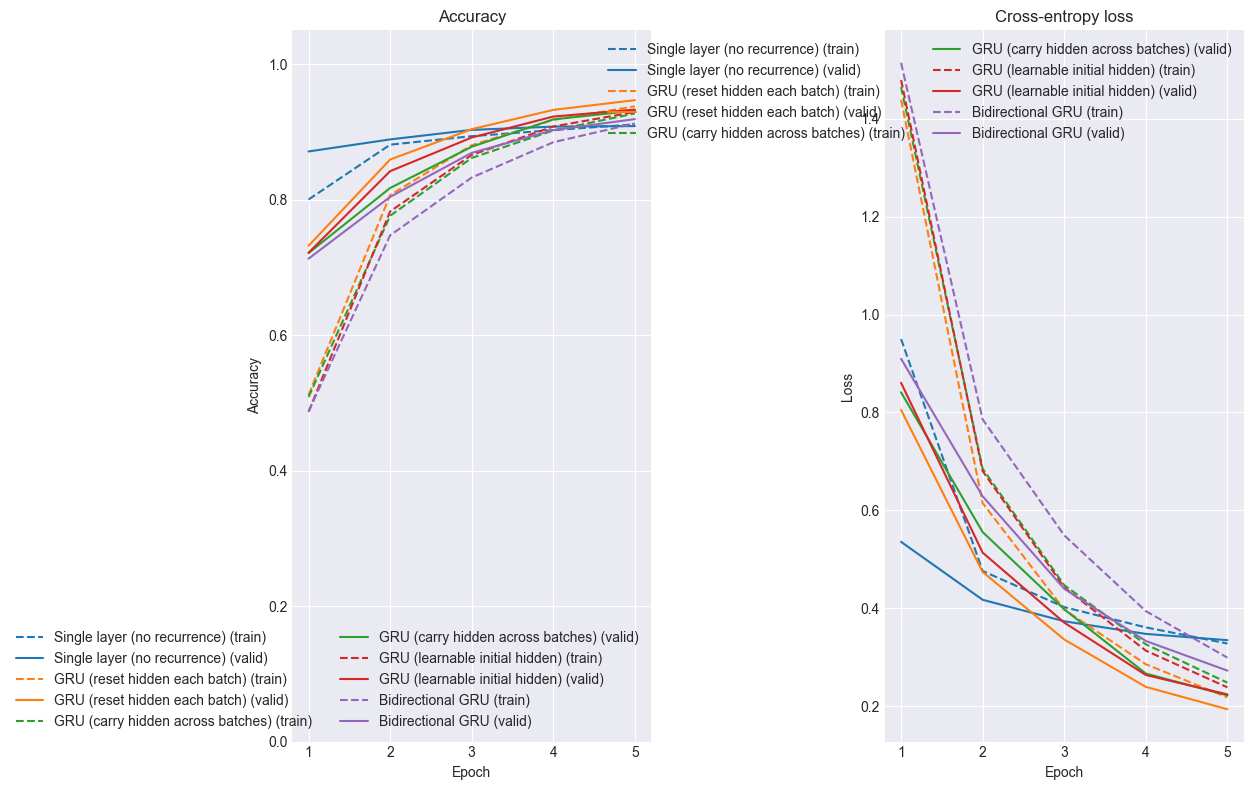

In [14]:
epochs = np.arange(1, NUM_EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for key, exp in EXPERIMENTS.items():
    axes[0].plot(epochs, exp.history.train_acc, linestyle='--', color=exp.color, label=f"{exp.label} (train)")
    axes[0].plot(epochs, exp.history.valid_acc, linestyle='-', color=exp.color, label=f"{exp.label} (valid)")
    axes[1].plot(epochs, exp.history.train_loss, linestyle='--', color=exp.color, label=f"{exp.label} (train)")
    axes[1].plot(epochs, exp.history.valid_loss, linestyle='-', color=exp.color, label=f"{exp.label} (valid)")

axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1.05)
axes[0].legend(loc='lower right', ncol=2)

axes[1].set_title('Cross-entropy loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


## Test-set summary

In [12]:
rows = []
for key, exp in EXPERIMENTS.items():
    test_loss, test_acc = exp.test_metrics
    rows.append({
        'Model': exp.label,
        'Carries hidden between batches?': 'Yes' if exp.carry_state else 'No',
        'Test loss': test_loss,
        'Test accuracy': test_acc,
    })

df_results = pd.DataFrame(rows).set_index('Model').sort_values('Test accuracy', ascending=False)
df_results


,Carries hidden between batches?,Test loss,Test accuracy
Model,,,
GRU (reset hidden each batch),No,0.214746,0.939688
GRU (learnable initial hidden),No,0.237404,0.930156
GRU (carry hidden across batches),Yes,0.250357,0.923125
Bidirectional GRU,No,0.293639,0.912188
Single layer (no recurrence),No,0.361238,0.900469


## Observations

- Resetting the GRU hidden state between batches gives the strongest validation/test accuracy in this short training run.
- A learnable initial hidden state recovers most of that performance without relying on the batch order, offering a controlled way to share global context.
- Carrying hidden state across batches still hurts optimisation because the context drifts with batch order, even though gradients do not flow through time across batches.
- The bidirectional GRU did not outperform the uni-directional GRU within five epochs, suggesting that additional capacity alone is not enough without longer training or tuned regularisation.
- The single-layer baseline lags behind all recurrent variants, reaffirming that sequential structure within MNIST images is informative when the model can exploit recurrence.